# High velocity food transport: a study in projectile cattle
### Jonathan Kelley and Solomon Greenberg

![he](images/flyingcow.jpg)

2018 has been a crazy year for technology. Smartphones are up to 89.6% screen-to-body ratio. Fidget spinners took over the world by storm. IoT-connected toilets now track your bowel movements and let you share it with your friends. 

Despite the incredible advances in humanity's cutting edge, the field of high velocity food transport remains nearly silent. However, Elon Musk's proposed rocket transport concepts might indeed change the farm-to-fork experience for our daily bread.  

While Musk might understand the logistics of supply chain and have a degree in engineering, he is still thinking "inside-the-box." We see the most efficient high-velocity food transport system completely void of rockets - fuel is expensive, big explosions are common, and it shouldn't take several million dollars to launch your next Big Mac from SanFran to Boston. Our goal: launch cattle across the state of Massachussets without a rocket. 


A big catapult should do the trick.

Ideally, our beachhead market would be the type of cattle that is most efficient to launch - our catapult can be cheaper and we can launch higher quantities. At least that's what the "suits upstairs" said.

Anyways, we need to figure out which cattle would fly the farthest for a fixed amount of weight.

To maintain consistency, we will be launching ~630 kg of each animal with a single shot

Our animals:

| Animal         | Mass (kg) | Quantity Per Launch |
|----------------|-----------|---------------------|
| Chicken        | 6.35      | 99                  |
| Cow            | 630.49    | 1                   |
| Goat           | 124.74    | 5                   |
| Pig            | 127.91    | 5                   |
| Sheep          | 113.31    | 5                   |
| Fish (Tilapia) | 2.27      | 228                 |

sidebar: a fishing vessel that can launch the fish back to shore is actually a decent business idea.

### Robust and Versatile!

We'd love to be able to launch any plane/train/animal that our heart so desires, so we need a robust physics model. The four fundamental forces of the universe include:
- Strong force
- Weak Force
- Gravity
- Electromagnetism

Obviously, this is too general for us to write a single "net force" function, so our model will allow users to input their own force function that returns a force from the object's state.

We also need some understanding of the object's aerodynamic properties (surprisingly falls under electromagnetism).
We could either generalize the flight physics or write our own 2D computational fluid dynamics solver.

We wrote our own CFD solver to handle images (emoji too)!

In [1]:
from modsim_cfd import image2cdf, emoji2cdf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

### Behind the scenes

The CFD solver takes the input image and converts it to a 2D array. We can then solve the Navier-Stokes fluid equations where the left-most boundary conditions sets the air flow at fixed initial momentum.

By analyzing the momemntum drop of the fluid as it is solved around the input image, we can get values for the coefficients of drag and lift. More analysis can determine other characteristics like skin friction and form friction, but we are assuming turbulent fluid flow regardless of the object shape. 

![Example of Navier-Stokes solved around a pig](images/pignavier.png)

### Building a projectile model

We can treat each animal as a rigid body with a mass, position, velocity, and net acceleration.

Each animal also has the coefficients of drag and lift that we determined with the CFD solver.

In [2]:
class state:
    def __init__(self):
        pass
    
class projectile:
    def __init__(self, image, image_width = 1, 
                              mass = 1, 
                              dt = .1, 
                              is_emoji = False, 
                              cl = 0, 
                              cd = 0,
                              wing_area = 0,
                              frontal_area = 0,
                              name = 'generic animal'):
        '''
        Initalize a template projectile with basic 2D properties.
        This function requires a profile (image) to be passed in as a string.
        This string can either be the file location to the image or the unicode for an emoji.
        Make sure to set the is_emoji parameter to true when relevant.
        '''
        self.state = state()
        
        self.state.position = np.array([0,0], dtype = np.float64)
        self.positions = []
        
        self.state.velocity = np.array([0,0], dtype = np.float64)
        self.velocities = []

        self.state.acceleration = np.array([0,0], dtype = np.float64)
        self.accelerations = []
        
        self.state.dt = dt
        self.state.t = 0
        self.times = []
        
        self.state.mass = mass
        
        self.is_emoji = is_emoji
        
        self.forces = []
        
        self.image = image
        self.image_width = image_width
        
        self.name = name
        
        self.define_aerodynamics(self.is_emoji)
        
        # Aerodynamics override to precompute the cl/cd values
        if cl != 0:
            self.state.cl = cl
            
        if cd != 0:
            self.state.cd = cd
            
        if wing_area != 0:
            self.state.wing_area = wing_area
            
        if frontal_area != 0:
            self.state.frontal_area = frontal_area
                
        
        
    def define_aerodynamics(self, is_emoji = False):
        '''
        Using the modsim_cdf package, we can generate relevant aerodynamic properties of whatever image we want.
        This function will use the relevant solver based on the is_emoji flag. 
        The current output properties are the coefficients of lift and drag.
        '''
        if is_emoji:
            aerodynamics = emoji2cdf(self.image, 
                                     self.emoji_width)
        else:
            aerodynamics = image2cdf(self.image, 
                                     self.image_width)
            
        self.state.cd = aerodynamics['coefficient_of_drag']
        self.state.cl = aerodynamics['coefficient_of_lift']
        self.state.wing_area = aerodynamics['wing_area']
        self.state.frontal_area = aerodynamics['frontal_area']
        self.aerodynamic_properties = aerodynamics['properties']
        
    def update_state(self, position = 0, velocity = 0, acceleration = 0, dt = 0):#, position = self.position, velocity = self.velocity, acceleration = self.acceleration, dt = self.dt):
        '''
        Updates the state of the object and adds state to state history
        dt can be overrriden for adaptive time step algorithms but defaults to the intial timestep        
        '''
        
        self.state.position = position
        self.positions.append(position.tolist())

        self.state.velocity = velocity
        self.velocities.append(velocity.tolist())
                
        self.state.acceleration = acceleration
        self.accelerations.append(acceleration.tolist())
        
        self.state.t += self.state.dt
        self.times.append(self.state.t)
    
    def add_force(self, force_function):
        self.forces.append(force_function)

    def get_accel(self, new_position = np.array([0.0, 0.0])):
        '''
        Loops through the associated force functions and returns a net acceleration
        '''
        
        net_force = np.array([0.0, 0.0])
        
        for each_force in self.forces:
            new_force = each_force(self.state)
            net_force += new_force
        
        return(net_force/self.state.mass)

    def tick(self):#, dt = self.dt):
        '''
        Use a custom RK4 method to move the object.
        The default behavior is to use the dt of the object when initalized - this can be overridden with the dt parameter
        The defaukt behavior will also automatically log the state of the object every step, this can be set to 0 for never or n for striping
        '''
        velo = self.state.velocity
        pos = self.state.position
        dt = self.state.dt
    
        k1 = dt * self.get_accel();
        l1 = dt * velo;
        
        k2 = dt * self.get_accel(0.5 * l1);
        l2 = dt * (velo + (0.5 * k1));

        k3 = dt * self.get_accel(pos + (0.5 * l2) );
        l3 = dt * (velo + (0.5 * k2));

        k4 = dt * self.get_accel(pos + l3);
        l4 = dt * (velo + k3);

        velo += (k1 + (2.0 * k2) + (2.0 * k3) + k4) / 6.0;
        pos += (l1 + (2.0 * l2) + (2.0 * l3) + l4) / 6.0; 
        
        self.update_state(position = pos,
                          velocity = velo,
                          acceleration = self.get_accel())

### With the framework above, we can load and launch nearly any object we want with somewhat realistic physics

Our custom module `modsim_cdf` gives us useful information about the aerodynamic properties of whatever object we initialize. For instance, we can learn the drag and lift properties of a chicken from an image pulled from google:

![chicken](images/chicken.png)

In [3]:
chicken = projectile(image = 'images/chicken.png',
                     image_width = 0.6096,  #meters
                     mass = 1.25,          #kilograms
                     dt = .1)

chicken.aerodynamic_properties

1


or even from the emoji version (Apple's edition):

🐔


In [4]:
emoji_chicken = projectile(image = '🐔',
                           image_width = 0.6096,  #meters
                           mass = 1.25,          #kilograms
                           dt = .1)

chicken.aerodynamic_properties

1

### Launching our chickens.

When launching our animals, we are interested in the fluid interactions of the profiles in air. We also want to keep the kinetic energy of the catapult fixed for each test, so we will evenly distribute the total kinetic energy among each object launched.

To add realistic physics to our simulation, we need to start adding force interactions.

For an object flying through the air, our free-body diagram indicates that drag, lift, gravity, and thrust are relevant forces. We ultimately choose not to include other forces like interplanetary graviation or solar wind because of their minute impact on the simulation results for the current small scale. However, our model is flexible enough to add in these interactions at a later date.

In [5]:
def lift(object_state):
    '''
    Calculates a lift vector normal to the velocity path of the object
    
    L = Cl * A * (0.5 * rho * V^2)
    
    '''
    rho = 1.225 # kg/m^3
    
    
    
    perp_velocity = np.array([-object_state.velocity[1], object_state.velocity[0]]) 
    #perp_velocity = perp_velocity / np.sqrt(perp_velocity.dot(perp_velocity))
    perp_velocity = perp_velocity / np.sqrt(perp_velocity[0]**2.0 + perp_velocity[1]**2.0)
    
    lift = object_state.cl * object_state.wing_area * rho * 0.5 * (object_state.velocity)**2.0
    
    return perp_velocity * lift

In [6]:
def drag(object_state):
    '''
    Calculates the drag vector
    
    D = Cd * A * (0.5 * rho * V^2)
    
    '''
    rho = 1.225 # kg/m^3
    
    velocity = object_state.velocity * -1
    velocity = velocity / np.sqrt(velocity.dot(velocity))    
    drag = object_state.cd * object_state.frontal_area * rho * 0.5 * (object_state.velocity)**2.0
    
    return drag * velocity

In [7]:
def gravity(object_state):
    '''
    Calculats the force of gravity
    
    F = MG
    '''
    G = np.array([0, -9.8]) # m / s ^2
    return object_state.mass * G

In [8]:
def launch_end_condition(object_state):
    return object_state.position[1] < 0

### Need a launcher

We know have a representation of the physics of flight and a robust way of generated useful aerodynamics data for each object entered into the simulation. However, we don't yet have a system to launch the animals and collect the data.

In [9]:
class launcher:
    def __init__(self, release_height = 15 ):
        self.release_position = np.array([0.0, release_height])
        pass
    
    def load_projectile(self, projectile, num_projectiles = 1):
        '''
        Sets the initial conditions for the loaded projectiles
        '''
        self.projectile = projectile
        self.projectile.state.position = self.release_position
        self.num_projectiles = num_projectiles
        
    def launch(self, launch_end_condition, kinetic_energy, launch_angle = np.radians(45), cl = 0, cd = 0):
        '''
        Set the initial velocity for the projectiles
        Run their "tick()" functions until the end condition is met
        Build the results object for easy data analysis
        '''
        ke_per_projectile = kinetic_energy/self.num_projectiles
        velocity_norm = np.array([np.cos(launch_angle), np.sin(launch_angle)])

        vel_mag = np.sqrt(2.0 * ke_per_projectile / self.projectile.state.mass)
        self.projectile.state.velocity = velocity_norm * vel_mag
        
        while not launch_end_condition(self.projectile.state):
            self.projectile.tick()
        


### Flight data for 99 chickens:

In [10]:
catapult = launcher()

chicken = projectile(image = 'images/chicken.png',
                     mass = 1.25,
                     dt = .01)

chicken.add_force(lift) 
chicken.add_force(drag)
chicken.add_force(gravity)

catapult.load_projectile(chicken, num_projectiles = 99)
catapult.launch(launch_end_condition,
                kinetic_energy = 1000000,
                launch_angle = np.radians(45))

#plt.figure(dpi = 200)
#plt.plot(chicken.results['Time'], chicken.results['Position'], label = 'Position vs. Time')

Text(0, 0.5, 'Height (m)')

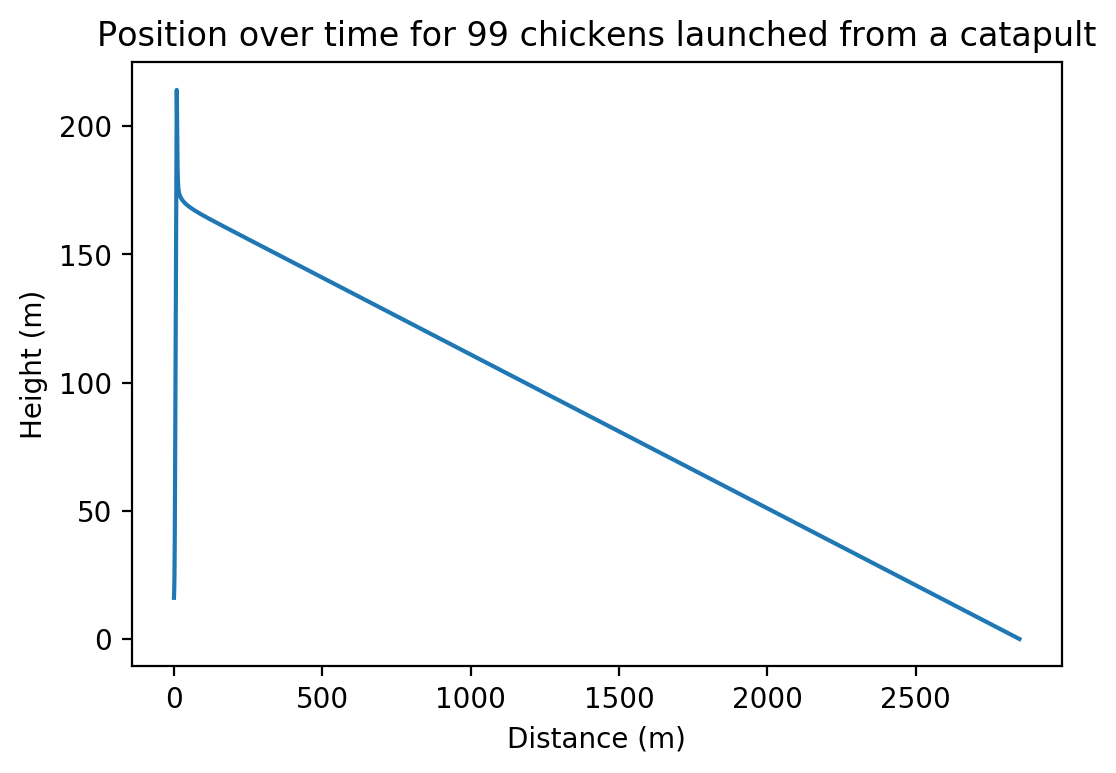

In [11]:
plt.figure(dpi = 200)
positions = np.array(chicken.positions)
plt.plot(positions[:,0], positions[:,1])
plt.title("Position over time for 99 chickens launched from a catapult")
plt.xlabel("Distance (m)")
plt.ylabel("Height (m)")

### Flight data for the other animals:

| Animal         | Mass (kg) | Quantity Per Launch |
|----------------|-----------|---------------------|
| Chicken        | 6.35      | 99                  |
| Cow            | 630.49    | 1                   |
| Goat           | 124.74    | 5                   |
| Pig            | 127.91    | 5                   |
| Sheep          | 113.31    | 5                   |
| Fish (Tilapia) | 2.27      | 228                 |

### Launching all the different animals:

The CFD solver takes a while to run so it's faster for us to enter in the precomputed values.

If you're interested in how the CFD solver works, feel free to delve into the depths of `modsim_cfd.py` and `cfd2.py`. 

In [15]:
animals = {"chicken": {'num_animals' : 99,  'mass' : 6.35,   'cl':0.32 , 'cd':0.18 , 'wing_area':0.67, 'frontal_area':0.67, 'image' : 'images/chicken.png'},
           "cow":     {'num_animals' : 1,   'mass' : 630.49, 'cl':0.30 , 'cd':0.27 , 'wing_area':4.0,  'frontal_area':2.0,  'image' : 'images/cow.png'},
           "goat":    {'num_animals' : 5,   'mass' : 124.74, 'cl':0.37 , 'cd':0.25 , 'wing_area':3.0,  'frontal_area':1.5,  'image' : 'images/goat.png'},
           "pig":     {'num_animals' : 5,   'mass' : 124.74, 'cl':0.28 , 'cd':0.27 , 'wing_area':2.5,  'frontal_area':1.25, 'image' : 'images/pig.png'},
           "sheep":   {'num_animals' : 5,   'mass' : 113.91, 'cl':0.28 , 'cd':0.26 , 'wing_area':2.5,  'frontal_area':1.0,  'image' : 'images/sheep.png'},
           "tilapia": {'num_animals' : 228, 'mass' : 1.25,   'cl':0.23 , 'cd':0.21 , 'wing_area':0.5,  'frontal_area':0.25, 'image' : 'images/tilapia.png'}}
           
animal_data = []
for animal, properties in (animals.items()):
    catapult = launcher()

    animal_sim = projectile(image = properties['image'],
                            mass = properties['mass'],
                            cl = properties['cl'],
                            cd = properties['cd'],
                            wing_area = properties['wing_area'],
                            frontal_area = properties['frontal_area'],
                            name = animal,
                            dt = .01)

    animal_sim.add_force(lift)
    animal_sim.add_force(drag)
    animal_sim.add_force(gravity)

    catapult.load_projectile(animal_sim, num_projectiles = properties['num_animals'])
    catapult.launch(launch_end_condition,
                    kinetic_energy = 1e6,
                    launch_angle = np.radians(45))
    animal_data.append(animal_sim)

### Results:

For each animal, we have position, velocity, and acceleration vs time data. For the sake of this project, we are primarily curious in the greatest horizontal position achieved. The animals with the greatest horizontal position will have traveled the farthest for a fixed amount of kinetic energy and starting mass.

This is given below:

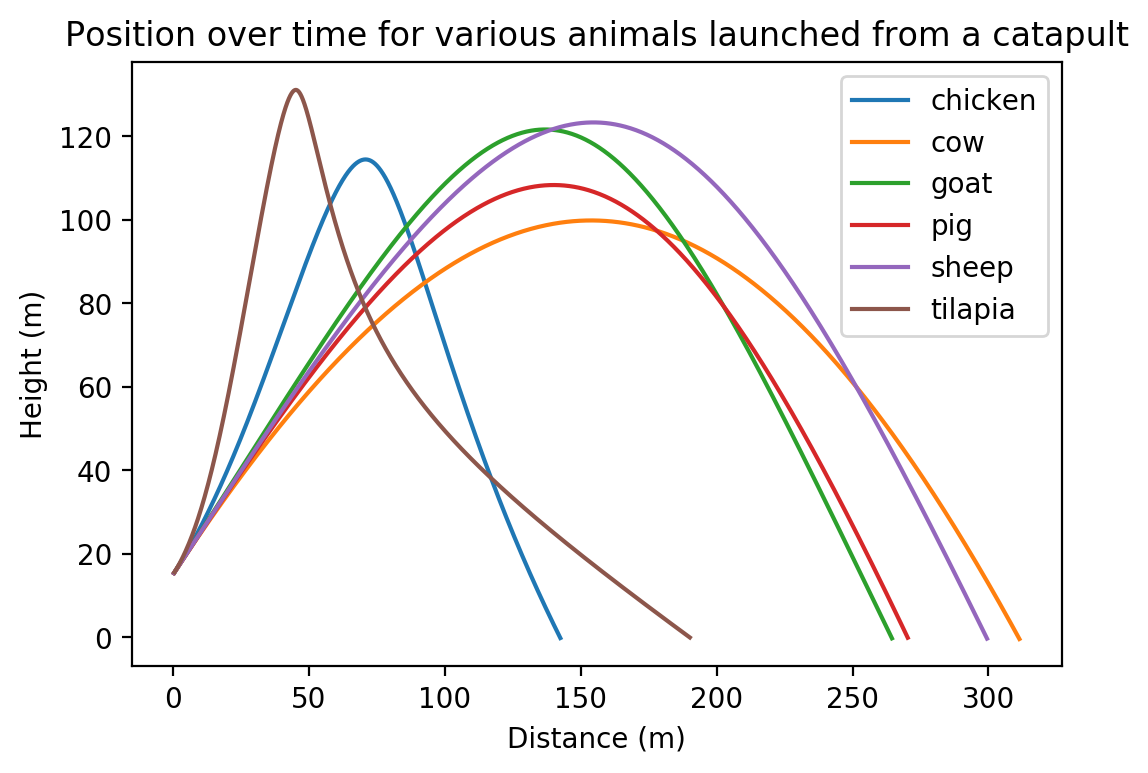

In [17]:
plt.figure(dpi = 200)
for animal in animal_data:
    positions = np.array(animal.positions)
    plt.plot(positions[:,0], positions[:,1], label = animal.name)
    plt.xlabel("Distance (m)")
    plt.ylabel("Height (m)")
    animal.max_distance = positions[:,0][-1]

plt.title("Position over time for various animals launched from a catapult")
plt.legend()

Text(0.5, 1.0, 'Distances thrown for 630 kg of each animal')

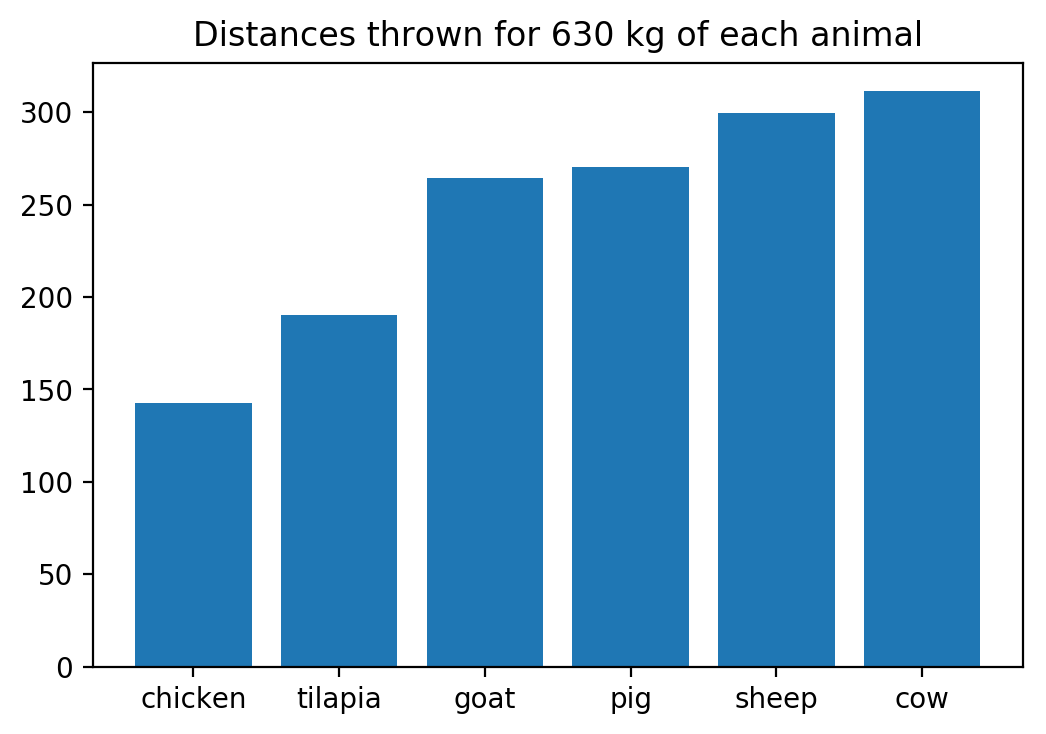

In [18]:
plt.figure(dpi = 200)
animal_names = []
animal_distance = []
for each_animal in animal_data:
    animal_names.append(each_animal.name)
    animal_distance.append(each_animal.max_distance)
    
idx = np.argsort(animal_distance)
plt.bar(np.array(animal_names)[idx], np.array(animal_distance)[idx])

plt.title("Distances thrown for 630 kg of each animal")
    

Text(0.5, 1.0, 'Impact kinetic energies for 630 kg of each animal')

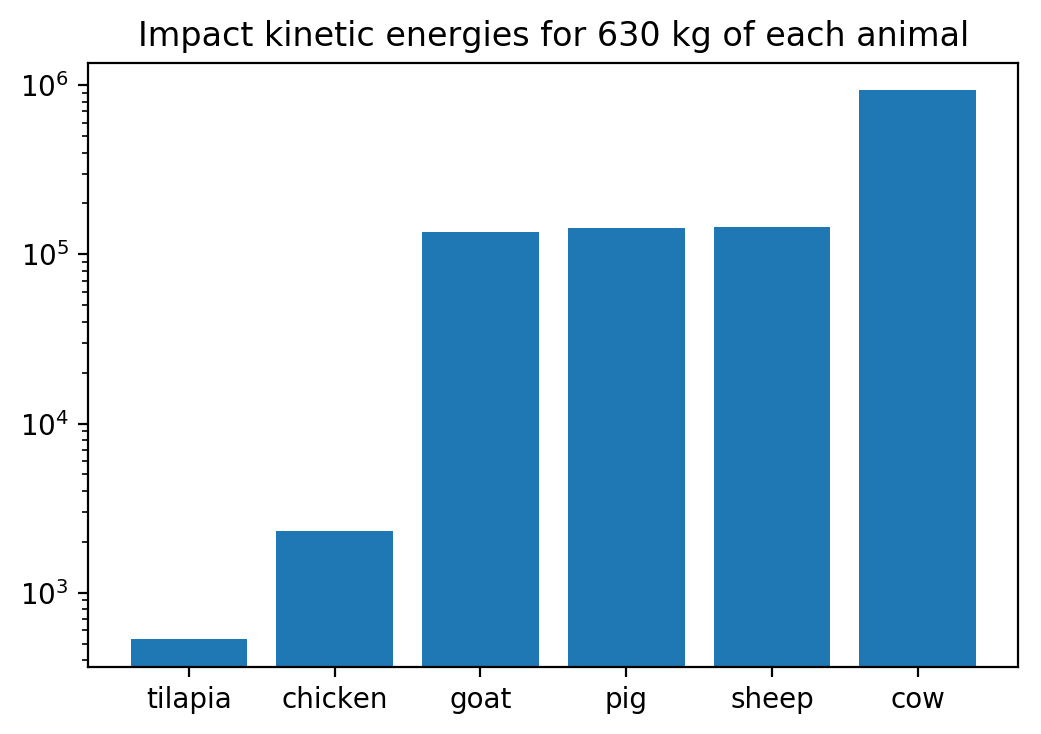

In [19]:
plt.figure(dpi = 200)
animal_names = []
animal_energies = []
for each_animal in animal_data:
    final_ke = 0.5 * each_animal.state.mass * each_animal.state.velocity.dot(each_animal.state.velocity)
    animal_names.append(each_animal.name)
    animal_energies.append(final_ke)
    
idx = np.argsort(animal_energies)
plt.bar(np.array(animal_names)[idx], np.array(animal_energies)[idx])
plt.gca().set_yscale("log", nonposy='clip')


plt.title("Impact kinetic energies for 630 kg of each animal")
    

### Interpretations:

Unsurprisingly, the heavier animals were able to be thrown farther for the same amount of kinetic energy. For every cow thrown, we threw 99 chickens, each with a smaller mass. While the chickens and tilapia did have respectable glide times and vertical climb, they quickly ran out of horizontal velocity and entered descent. The cow and pig acted much more like cannonballs and traveled like normal projectiles.

An interesting metric to study is the glide ratio, or the ratio between the products of the drag and lift coefficients with their respective frontal and wing area values. The chicken and tilapia had very high glide ratios, but also high drag values. Because of their higher sensitivity to drag, they lose much of their horizontal velocity early on while climbing rapidly. The tilapia flew significantly higher than the rest of the animals and glided fairly signficantly ~200 meters.

Each launch was performed with 1 million Joules of energy being dissapated into 630 kg of mass. For the lighter animals, the 1e6 joules was even distributed to each animal, meaning each individual fish was launched with 4386 Joules of energy.

### Conclusions:

Our startup idea might indeed have legs!

Tilapia had a surprsingly high glide ratio and could likely have an optimal launch angle that would enable high velocity food transport from the ocean to the shore. This might be useful one day when the ports are too crowded or boats operate on solar power - it would be more efficient to railgun the food back to shore than to drive the boat back.


Our project could be used to model interplanetary food deployment too - useful for emergency rescue missions or lightweight cargo deplyoment.

An ideal animal would launch far and come down with a significant glide. The tilapia, despite having the second worst launch distancce, comes down with a highly favorable velocity. While the cows would "splat" into the ground, the tilapia would (relatively) gently touch the floor.



